In [112]:
import numpy as np
import pandas as pd
import torch

from itertools import islice, combinations, chain
from tqdm import tqdm
from collections import defaultdict, Counter
from cached_property import cached_property
from scipy import random

from news_vec.utils import read_json_gz_lines
from news_vec import logger

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [21]:
class Actors:
    
    def __init__(self, root, skim=None):
        self.root = root
        self.skim = skim
        
    def __iter__(self):
        reader = islice(read_json_gz_lines(self.root), self.skim)
        yield from tqdm(reader)

In [22]:
ac = Actors('../data/clf-actors.json/', 10000000)

In [23]:
ACTOR_DOMAINS = defaultdict(set)

for row in ac:
    ACTOR_DOMAINS[row['actor_id']].add(row['domain'])

10000000it [00:35, 277958.37it/s]


In [24]:
ACTOR_DOMAINS['id:twitter.com:2793391472']

{'apnews.com',
 'buzzfeed.com',
 'cnn.com',
 'dailykos.com',
 'foxnews.com',
 'huffingtonpost.com',
 'npr.org',
 'nytimes.com',
 'thehill.com',
 'washingtonpost.com',
 'wsj.com'}

In [25]:
DOMAIN_PAIRS = []
for _, domains in tqdm(ACTOR_DOMAINS.items()):
    if len(domains)==2:
        DOMAIN_PAIRS.append(tuple(sorted(domains)))

100%|██████████| 2662161/2662161 [00:01<00:00, 1746306.90it/s]


In [27]:
len(DOMAIN_PAIRS)

377959

In [28]:
DOMAIN_PAIR_COUNTS = Counter(DOMAIN_PAIRS)

In [29]:
DOMAINS, DOMAIN_COUNTS = zip(*Counter(chain(*map(list, DOMAIN_PAIRS))).most_common())

In [30]:
DOMAINS

('cnn.com',
 'nytimes.com',
 'huffingtonpost.com',
 'foxnews.com',
 'buzzfeed.com',
 'bloomberg.com',
 'washingtonpost.com',
 'apnews.com',
 'breitbart.com',
 'thehill.com',
 'npr.org',
 'dailycaller.com',
 'rt.com',
 'wsj.com',
 'dailykos.com',
 'sputniknews.com')

In [73]:
DOMAIN_COUNTS

(186687,
 71015,
 69620,
 69077,
 68779,
 52480,
 39316,
 38942,
 37928,
 37121,
 35194,
 21978,
 9961,
 9447,
 6797,
 1576)

In [91]:
DOMAIN_PRIOR = np.array(DOMAIN_COUNTS)
DOMAIN_PRIOR = DOMAIN_PRIOR / DOMAIN_PRIOR.sum()
DOMAIN_PRIOR = torch.from_numpy(DOMAIN_PRIOR).view(1, -1)

In [92]:
DOMAIN_PRIOR

tensor([[0.2470, 0.0939, 0.0921, 0.0914, 0.0910, 0.0694, 0.0520, 0.0515, 0.0502,
         0.0491, 0.0466, 0.0291, 0.0132, 0.0125, 0.0090, 0.0021]],
       dtype=torch.float64)

In [103]:
SAMPLED_DOMAIN_PAIR_COUNTS = defaultdict(list)

for _ in tqdm(range(100)):
    
    samples = torch.multinomial(DOMAIN_PRIOR.repeat(len(DOMAIN_PAIRS), 1), 2)
    
    pairs = []
    for i1, i2 in samples.tolist():
        pair = tuple(sorted([DOMAINS[i1], DOMAINS[i2]]))
        pairs.append(pair)
        
    counts = Counter(pairs)
    for p, count in counts.items():
        SAMPLED_DOMAIN_PAIR_COUNTS[p].append(count)

100%|██████████| 100/100 [02:18<00:00,  1.45s/it]


In [110]:
rows = []
for pair, count in DOMAIN_PAIR_COUNTS.items():
    sampled_counts = SAMPLED_DOMAIN_PAIR_COUNTS[pair]
    zscore = (count - np.mean(sampled_counts)) / np.std(sampled_counts)
    rows.append((pair, zscore))

In [116]:
zdf = pd.DataFrame(rows, columns=('pair', 'zscore'))
zdf.sort_values('zscore', ascending=False, inplace=True)

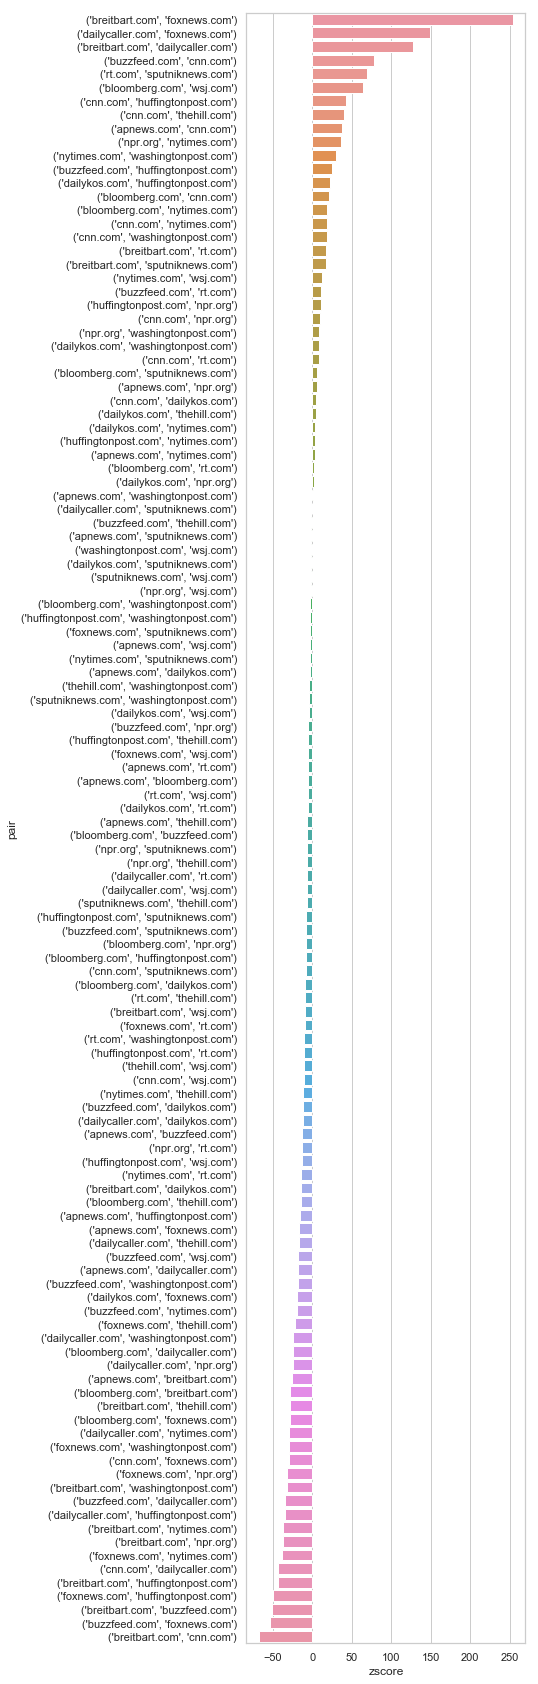

In [118]:
plt.figure(figsize=(5,30))
sns.barplot(x='zscore', y='pair', data=zdf)